This will extract only the online transactions and see what can be done to optimize the data for a ML model

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, precision_recall_curve, auc
import category_encoders as ce

In [23]:
df = pd.read_csv("./Dataset/preprocessed_dataset_v2.csv", index_col=0)
df.head()

,Year,Month,Day,Hour,Minute,Payment Method,Amount,Category,Is Fraud?
0,2002,9,1,6,21,on-site,134.09,Personal Spending,No
1,2002,9,1,6,42,on-site,38.48,Food/Groceries,No
2,2002,9,2,6,22,on-site,120.34,Food/Groceries,No
3,2002,9,2,17,45,on-site,128.95,Clothing,No
4,2002,9,3,6,23,on-site,104.71,Healthcare,No


In [24]:
df = df[df["Payment Method"] == "online"]
df.head()

,Year,Month,Day,Hour,Minute,Payment Method,Amount,Category,Is Fraud?
11,2002,9,5,20,41,online,53.91,Utilities,No
23,2002,9,9,20,2,online,144.90,Subscriptions,No
79,2002,9,30,6,21,online,127.32,Clothing,No
93,2002,10,6,6,14,online,139.39,Clothing,No
100,2002,10,9,8,16,online,53.09,Personal Spending,No


In [25]:
# drop the "Payment Method" column
df.drop(columns="Payment Method", inplace=True)
df.head()

,Year,Month,Day,Hour,Minute,Amount,Category,Is Fraud?
11,2002,9,5,20,41,53.91,Utilities,No
23,2002,9,9,20,2,144.90,Subscriptions,No
79,2002,9,30,6,21,127.32,Clothing,No
93,2002,10,6,6,14,139.39,Clothing,No
100,2002,10,9,8,16,53.09,Personal Spending,No


In [26]:
# reset the index
df.reset_index(inplace=True)
df.head()

,index,Year,Month,Day,Hour,Minute,Amount,Category,Is Fraud?
0,11,2002,9,5,20,41,53.91,Utilities,No
1,23,2002,9,9,20,2,144.90,Subscriptions,No
2,79,2002,9,30,6,21,127.32,Clothing,No
3,93,2002,10,6,6,14,139.39,Clothing,No
4,100,2002,10,9,8,16,53.09,Personal Spending,No


In [27]:
df.shape

(2651766, 9)

In [28]:
# find the number of different values in the "Is Fraud?" column
is_fraud_counts = df["Is Fraud?"].value_counts()
is_fraud_counts

Is Fraud?
No     2634224
Yes      17542
Name: count, dtype: int64

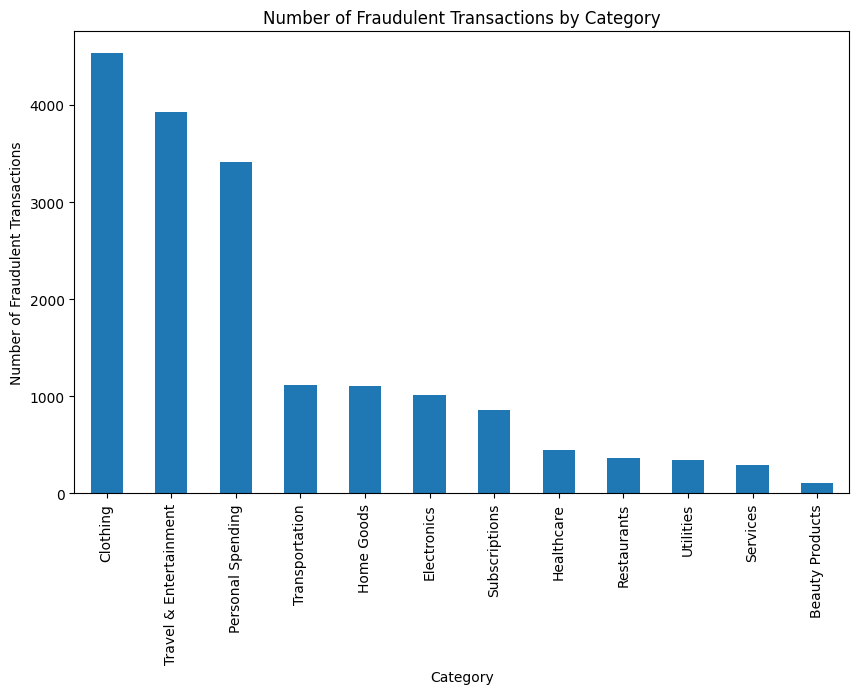

In [29]:
import matplotlib.pyplot as plt

# Assuming 'df' is the dataframe and it has a column 'Category' and 'Fraudulent'
fraudulent_transactions = df[df['Is Fraud?'] == "Yes"]
fraudulent_counts = fraudulent_transactions['Category'].value_counts()

plt.figure(figsize=(10, 6))
fraudulent_counts.plot(kind='bar')
plt.title('Number of Fraudulent Transactions by Category')
plt.xlabel('Category')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()


In [30]:
encoder = ce.BinaryEncoder(cols='Category')
df_encoded = encoder.fit_transform(df['Category'])

df = df.drop(columns='Category')
df = pd.concat([df, df_encoded], axis=1)

df['Is Fraud?'] = df['Is Fraud?'].apply(lambda x: 1 if x == 'Yes' else 0)

In [31]:
x = df.drop(columns=['Is Fraud?'])
y = df['Is Fraud?']

In [32]:
x

,index,Year,Month,Day,Hour,Minute,Amount,Category_0,Category_1,Category_2,Category_3
0,11,2002,9,5,20,41,53.91,0,0,0,1
1,23,2002,9,9,20,2,144.90,0,0,1,0
2,79,2002,9,30,6,21,127.32,0,0,1,1
3,93,2002,10,6,6,14,139.39,0,0,1,1
4,100,2002,10,9,8,16,53.09,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2651761,23998426,2020,2,24,20,4,55.79,1,0,0,0
2651762,23998428,2020,2,25,7,6,43.08,1,0,0,0
2651763,23998429,2020,2,25,7,34,43.76,1,0,0,0
2651764,23998433,2020,2,26,7,43,45.18,1,0,0,0


In [33]:
y

0          0
1          0
2          0
3          0
4          0
          ..
2651761    0
2651762    0
2651763    0
2651764    0
2651765    0
Name: Is Fraud?, Length: 2651766, dtype: int64

In [34]:
x_train, x_test, y_train,y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

In [35]:
from xgboost import XGBClassifier

In [36]:
xgb_cl = XGBClassifier(scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]))
xgb_cl.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [41]:
y_pred = xgb_cl.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[499697  27149]
 [   203   3305]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    526846
           1       0.11      0.94      0.19      3508

    accuracy                           0.95    530354
   macro avg       0.55      0.95      0.58    530354
weighted avg       0.99      0.95      0.97    530354


Accuracy Score:
Accuracy: 0.9484

Precision Score:
Precision: 0.1085

Recall Score:
Recall: 0.9421

Model Summary

Precision-Recall AUC: 0.5856


In [42]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


#grid_search = GridSearchCV(estimator=, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

#grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator=xgb_cl, param_distributions=param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2, scoring='recall', random_state=42)

random_search.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [12:37:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='recall', verbose=2)

In [43]:
y_pred = random_search.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, random_search.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[492844  34002]
 [   181   3327]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    526846
           1       0.09      0.95      0.16      3508

    accuracy                           0.94    530354
   macro avg       0.54      0.94      0.56    530354
weighted avg       0.99      0.94      0.96    530354


Accuracy Score:
Accuracy: 0.9355

Precision Score:
Precision: 0.0891

Recall Score:
Recall: 0.9484

Model Summary

Precision-Recall AUC: 0.5467


In [44]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}


#grid_search = GridSearchCV(estimator=, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2, scoring='accuracy')

#grid_search.fit(x_train, y_train)
random_search2 = RandomizedSearchCV(estimator=xgb_cl, param_distributions=param_grid, n_iter=100, cv=3, n_jobs=-1, verbose=2, scoring='f1', random_state=42)

random_search2.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:55:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "bootstrap", "min_samples_leaf", "min_samples_split" } are not used.

  warnings.warn(smsg, UserWarning)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='f1', verbose=2)

In [45]:
y_pred = random_search2.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, random_search2.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[526056    790]
 [  1701   1807]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.70      0.52      0.59      3508

    accuracy                           1.00    530354
   macro avg       0.85      0.76      0.79    530354
weighted avg       0.99      1.00      0.99    530354


Accuracy Score:
Accuracy: 0.9953

Precision Score:
Precision: 0.6958

Recall Score:
Recall: 0.5151

Model Summary

Precision-Recall AUC: 0.6447


In [47]:
rs1=random_search.best_estimator_
rs2=random_search2.best_estimator_
print("\n",rs1)
print("\n",rs2)




 XGBClassifier(base_score=None, booster=None, bootstrap=True, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, min_samples_leaf=2, min_samples_split=10,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=50, ...)

 XGBClassifier(base_score=None, booster=None, bootstrap=False, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_

In [106]:
#targt 60: recall 61: precision 61: f1-score
xgb_cl_optimized = XGBClassifier(
    n_estimators=200,
    max_depth=20,
    min_child_weight=4,  # Correct parameter name for XGBoost
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)

# Train the classifier
xgb_cl_optimized.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [113]:
y_pred = xgb_cl_optimized.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525502   1344]
 [  1400   2108]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.61      0.60      0.61      3508

    accuracy                           0.99    530354
   macro avg       0.80      0.80      0.80    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9948

Precision Score:
Precision: 0.6107

Recall Score:
Recall: 0.6009

Model Summary

Precision-Recall AUC: 0.6723


In [116]:
#targt 60: recall 61: precision 61: f1-score
xgb_cl_optimized1 = XGBClassifier(
    n_estimators=200,
    max_depth=20,
    min_child_weight=4,  # Correct parameter name for XGBoost
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.075,
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    random_state=42
)

# Train the classifier
xgb_cl_optimized1.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=4, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [117]:
y_pred = xgb_cl_optimized1.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized1.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525433   1413]
 [  1374   2134]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.60      0.61      0.60      3508

    accuracy                           0.99    530354
   macro avg       0.80      0.80      0.80    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9947

Precision Score:
Precision: 0.6016

Recall Score:
Recall: 0.6083

Model Summary

Precision-Recall AUC: 0.6717


In [152]:
xgb_cl_optimized2 = XGBClassifier(
    n_estimators=300,  # Increased number of trees
    max_depth=20,  # Slightly reduced depth
    min_child_weight=4,  # Increased to control overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    learning_rate=0.075,  # Adjusted learning rate
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_delta_step=1,
    reg_alpha=0.2,  # Increased L1 regularization
    reg_lambda=1.5,  # Increased L2 regularization
    random_state=42
)

# Train the classifier
xgb_cl_optimized2.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True)

[0]	validation_0-logloss:0.66667	validation_1-logloss:0.66673
[1]	validation_0-logloss:0.63895	validation_1-logloss:0.63900
[2]	validation_0-logloss:0.61329	validation_1-logloss:0.61343
[3]	validation_0-logloss:0.58882	validation_1-logloss:0.58904
[4]	validation_0-logloss:0.56539	validation_1-logloss:0.56573
[5]	validation_0-logloss:0.54316	validation_1-logloss:0.54352
[6]	validation_0-logloss:0.51881	validation_1-logloss:0.51923
[7]	validation_0-logloss:0.49723	validation_1-logloss:0.49774
[8]	validation_0-logloss:0.47515	validation_1-logloss:0.47576
[9]	validation_0-logloss:0.45379	validation_1-logloss:0.45451
[10]	validation_0-logloss:0.43244	validation_1-logloss:0.43328
[11]	validation_0-logloss:0.41371	validation_1-logloss:0.41460
[12]	validation_0-logloss:0.39442	validation_1-logloss:0.39541
[13]	validation_0-logloss:0.37583	validation_1-logloss:0.37693
[14]	validation_0-logloss:0.35884	validation_1-logloss:0.36011
[15]	validation_0-logloss:0.34269	validation_1-logloss:0.34408
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=20, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [153]:
y_pred = xgb_cl_optimized2.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized2.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525453   1393]
 [  1324   2184]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.61      0.62      0.62      3508

    accuracy                           0.99    530354
   macro avg       0.80      0.81      0.81    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9949

Precision Score:
Precision: 0.6106

Recall Score:
Recall: 0.6226

Model Summary

Precision-Recall AUC: 0.6865


In [156]:
xgb_cl_optimized3 = XGBClassifier(
    n_estimators=300,  # Increased number of trees
    max_depth=30,  # Slightly reduced depth
    min_child_weight=4,  # Increased to control overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1.5,
    learning_rate=0.075,  # Adjusted learning rate
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_delta_step=1,
    reg_alpha=0.2,  # Increased L1 regularization
    reg_lambda=1.5,  # Increased L2 regularization
    random_state=42
)

# Train the classifier
xgb_cl_optimized3.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True)

[0]	validation_0-logloss:0.66613	validation_1-logloss:0.66620
[1]	validation_0-logloss:0.63832	validation_1-logloss:0.63838
[2]	validation_0-logloss:0.61197	validation_1-logloss:0.61215
[3]	validation_0-logloss:0.58643	validation_1-logloss:0.58672
[4]	validation_0-logloss:0.56189	validation_1-logloss:0.56233
[5]	validation_0-logloss:0.53949	validation_1-logloss:0.53995
[6]	validation_0-logloss:0.51489	validation_1-logloss:0.51542
[7]	validation_0-logloss:0.49142	validation_1-logloss:0.49212
[8]	validation_0-logloss:0.46911	validation_1-logloss:0.46991
[9]	validation_0-logloss:0.44720	validation_1-logloss:0.44815
[10]	validation_0-logloss:0.42513	validation_1-logloss:0.42622
[11]	validation_0-logloss:0.40566	validation_1-logloss:0.40685
[12]	validation_0-logloss:0.38624	validation_1-logloss:0.38753
[13]	validation_0-logloss:0.36683	validation_1-logloss:0.36826
[14]	validation_0-logloss:0.34862	validation_1-logloss:0.35029
[15]	validation_0-logloss:0.33191	validation_1-logloss:0.33370
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=30, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [158]:
y_pred = xgb_cl_optimized3.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized3.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525389   1457]
 [  1285   2223]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.60      0.63      0.62      3508

    accuracy                           0.99    530354
   macro avg       0.80      0.82      0.81    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9948

Precision Score:
Precision: 0.6041

Recall Score:
Recall: 0.6337

Model Summary

Precision-Recall AUC: 0.6899


In [172]:
xgb_cl_optimized4 = XGBClassifier(
    n_estimators=300,  # Increased number of trees
    max_depth=40,  # Slightly reduced depth
    min_child_weight=4,  # Increased to control overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1.5,
    learning_rate=0.075,  # Adjusted learning rate
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_delta_step=1,
    reg_alpha=0.4,  # Increased L1 regularization
    reg_lambda=1.5,  # Increased L2 regularization
    random_state=42
)

# Train the classifier
xgb_cl_optimized4.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True)

[0]	validation_0-logloss:0.66613	validation_1-logloss:0.66620
[1]	validation_0-logloss:0.63832	validation_1-logloss:0.63838
[2]	validation_0-logloss:0.61196	validation_1-logloss:0.61214
[3]	validation_0-logloss:0.58637	validation_1-logloss:0.58666
[4]	validation_0-logloss:0.56183	validation_1-logloss:0.56228
[5]	validation_0-logloss:0.53943	validation_1-logloss:0.53990
[6]	validation_0-logloss:0.51482	validation_1-logloss:0.51536
[7]	validation_0-logloss:0.49118	validation_1-logloss:0.49189
[8]	validation_0-logloss:0.46888	validation_1-logloss:0.46968
[9]	validation_0-logloss:0.44696	validation_1-logloss:0.44792
[10]	validation_0-logloss:0.42479	validation_1-logloss:0.42589
[11]	validation_0-logloss:0.40532	validation_1-logloss:0.40652
[12]	validation_0-logloss:0.38588	validation_1-logloss:0.38717
[13]	validation_0-logloss:0.36642	validation_1-logloss:0.36786
[14]	validation_0-logloss:0.34819	validation_1-logloss:0.34987
[15]	validation_0-logloss:0.33148	validation_1-logloss:0.33329
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.075, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=40, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [173]:
y_pred = xgb_cl_optimized4.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized4.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525403   1443]
 [  1276   2232]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.61      0.64      0.62      3508

    accuracy                           0.99    530354
   macro avg       0.80      0.82      0.81    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9949

Precision Score:
Precision: 0.6073

Recall Score:
Recall: 0.6363

Model Summary

Precision-Recall AUC: 0.6914


In [176]:
xgb_cl_optimized5 = XGBClassifier(
    n_estimators=300,  # Increased number of trees
    max_depth=40,  # Slightly reduced depth
    min_child_weight=4,  # Increased to control overfitting
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1.5,
    learning_rate=0.03,  # Adjusted learning rate
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),
    max_delta_step=1,
    reg_alpha=0.4,  # Increased L1 regularization
    reg_lambda=1.5,  # Increased L2 regularization
    random_state=42
)

# Train the classifier
xgb_cl_optimized5.fit(x_train, y_train,
    eval_set=[(x_train, y_train), (x_test, y_test)],
    verbose=True)

[0]	validation_0-logloss:0.68217	validation_1-logloss:0.68220
[1]	validation_0-logloss:0.67058	validation_1-logloss:0.67061
[2]	validation_0-logloss:0.65991	validation_1-logloss:0.65997
[3]	validation_0-logloss:0.64883	validation_1-logloss:0.64892
[4]	validation_0-logloss:0.63830	validation_1-logloss:0.63844
[5]	validation_0-logloss:0.62833	validation_1-logloss:0.62847
[6]	validation_0-logloss:0.61754	validation_1-logloss:0.61770
[7]	validation_0-logloss:0.60672	validation_1-logloss:0.60695
[8]	validation_0-logloss:0.59632	validation_1-logloss:0.59655
[9]	validation_0-logloss:0.58655	validation_1-logloss:0.58680
[10]	validation_0-logloss:0.57575	validation_1-logloss:0.57604
[11]	validation_0-logloss:0.56554	validation_1-logloss:0.56587
[12]	validation_0-logloss:0.55563	validation_1-logloss:0.55599
[13]	validation_0-logloss:0.54542	validation_1-logloss:0.54582
[14]	validation_0-logloss:0.53566	validation_1-logloss:0.53612
[15]	validation_0-logloss:0.52622	validation_1-logloss:0.52670
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1.5, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=1,
              max_depth=40, max_leaves=None, min_child_weight=4, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=300,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [178]:
y_pred = xgb_cl_optimized5.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nAccuracy Score:")
print(f"Accuracy: {accuracy:.4f}")

print("\nPrecision Score:")
print(f"Precision: {precision:.4f}")

print("\nRecall Score:")
print(f"Recall: {recall:.4f}")

print("\nModel Summary") 

# Calculate Precision-Recall AUC
precision, recall, _ = precision_recall_curve(y_test, xgb_cl_optimized5.predict_proba(x_test)[:, 1])
pr_auc = auc(recall, precision)
print(f"\nPrecision-Recall AUC: {pr_auc:.4f}")

#print(xgb_cl.summary())


Confusion Matrix:
[[525112   1734]
 [  1238   2270]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    526846
           1       0.57      0.65      0.60      3508

    accuracy                           0.99    530354
   macro avg       0.78      0.82      0.80    530354
weighted avg       0.99      0.99      0.99    530354


Accuracy Score:
Accuracy: 0.9944

Precision Score:
Precision: 0.5669

Recall Score:
Recall: 0.6471

Model Summary

Precision-Recall AUC: 0.6771


In [179]:
xgb_cl_optimized4.save_model("fraud_detection_model.json")